In [1]:
from sklearn.datasets import make_classification, make_regression, load_iris
from sklearn.model_selection import train_test_split
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

## Алгоритмы оптимизации

In [2]:
class Optimizer:
    def optimize(learning_rate, W, b, dW, db):
        pass

### SGD (Stochastic Gradient Descent)

In [3]:
class SGD(Optimizer):
    def optimize(self, learning_rate, W, b, dW, db):
        W -= learning_rate * dW
        b -= learning_rate * db
        return W, b

### Momentum SGD

In [4]:
class MomentumSGD(Optimizer):
    def __init__(self, gamma = 0.9):
        self.Vw, self.Vb = 0, 0
        self.gamma = gamma
  
    def optimize(self, learning_rate, W, b, dW, db):
        self.Vw, self.Vb = 0, 0

        self.Vw = (self.gamma * self.Vw) + ((1 - self.gamma) * dW)
        W -= learning_rate * self.Vw

        self.Vb = (self.gamma * self.Vb) + ((1 - self.gamma) * db)
        b -= learning_rate * self.Vb
        return W, b

### GradientClipping


In [35]:
class GradientClipping(Optimizer):
    def __init__(self, max_norm):
        self.max_norm = max_norm

    def optimize(self, learning_rate, W, b, dW, db):
        # Update weights and biases
        W -= learning_rate * dW
        b -= learning_rate * db
        
        # Clip gradients if necessary
        parameters = [W, b]
        self.clip_gradients(parameters)
        return W, b
    
    def clip_gradients(self, parameters):
        total_norm = 0.0

        for param in parameters:
            total_norm += np.linalg.norm(param)**2

        total_norm = np.sqrt(total_norm)

        if total_norm > self.max_norm:
            clip_coef = self.max_norm / (total_norm + 1e-6)

            for param in parameters:
                param *= clip_coef


## FrameWork

In [24]:
class NeuralFramework:

  def add_layers(self, layers, loss_function, optimizer=SGD(), 
                 learning_rate=0.02, epochs_count=20,
                 classification = True, regression = False):
    self.net = Net(layers) 
    self.loss_func = loss_function
    self.optimizer = optimizer
    self.lr = learning_rate
    self.epochs_count = epochs_count
    self.cls = classification
    self.rgr = regression

    if self.lr == 0.02:
        if isinstance(self.optimizer, MomentumSGD):
            self.lr = 0.2
        elif isinstance(self.optimizer, GradientClipping):
            self.lr = 0.99
        else:
            self.lr = 0.7

    if self.rgr == True:
        self.cls = False


  def train(self, X_train, Y_train):
    x, y = np.array(X_train), np.array(Y_train)
    n_obs = x.shape[0]

    batch_size = int(n_obs / 10)

    xy = np.c_[x.reshape(n_obs, -1), y.reshape(n_obs, 1)]
    rng = np.random.default_rng(seed = None)

    batch_count = int(n_obs // batch_size)

    print('Training model:')
    for epoch in range(self.epochs_count):
      rng.shuffle(xy)

      for batch in range(batch_count):
        start = batch * batch_size
        stop = start + batch_size

        x_batch, y_batch = xy[start:stop, :-1], xy[start:stop, -1:]

        if self.cls == True:
            y_batch = y_batch.astype('int32')

        # forward pass
        pred, loss = forward(x_batch, y_batch, self.net, self.loss_func)

        # backward pass
        backward(loss, self.lr, self.net, self.loss_func, self.optimizer)

      if self.cls == True:
          acc = accuracy(self.net, xy[:, :-1], xy[:, -1:])
          print(f"Epoch {epoch}: acc = {acc}")
      elif self.rgr == True:
          print(f"Epoch {epoch}: loss = {loss}")


  def predict(self, x_test, y_test):
    obs = x_test.shape[0]
    xy = np.c_[x_test.reshape(obs, -1), y_test.reshape(obs, 1)]
    x_test = xy[:, :-1]
    y_test = xy[:, -1:]

    if self.cls == True:
        y_test = y_test.astype('int32')

    preds = []

    for i in range(obs):
      pred, loss = forward(x_test, y_test, self.net, self.loss_func)

    if self.cls == True:
        pred = np.argmax(pred, axis=1)
        acc = (pred==y_test.astype('int32').flatten()).mean()
        return pred, acc

    elif self.rgr == True:
        preds.append(pred.flatten().tolist())
        return  np.array(preds).flatten(), ((np.array(preds).flatten() - y_test.flatten()) ** 2).mean()

## Перечисление нескольких слоёв

In [7]:
class Net:
  def __init__(self, layers):
    self.layers = layers

  def forward(self, x):
    for layer in self.layers:
      x = layer.forward(x)
    return x

  def backward(self, x):
    for layer in self.layers[::-1]:
      x = layer.backward(x)
    return x

  def update(self, learning_rate, optimizer):
    for layer in self.layers:
      if 'update' in layer.__dir__():
        layer.update(learning_rate, optimizer)

## Сумматор

In [9]:
class Linear:
  def __init__(self, nin, nout):
    self.W = np.random.normal(0, 1.0 / np.sqrt(nin), (nout, nin))
    self.b = np.zeros((1, nout))

  def forward(self, x):
    self.x = x
    return np.dot(x, self.W.T) + self.b


  def backward(self, dz):
    self.dW = np.dot(dz.T, self.x)
    self.db = dz.sum(axis=0)
    return np.dot(dz, self.W)

  def update(self, learning_rate, optimizer):
    self.W, self.b = optimizer.optimize(learning_rate, self.W, self.b, self.dW, self.db)

## Передаточные функции (функции активации)

### ReLU (Rectified Linear Unit)

In [10]:
class ReLU:
  def forward(self, x):
    self.y = np.maximum(0, x)
    return self.y

  def backward(self,dy):
    return np.multiply(dy, np.int64(self.y > 0))

### Tanh

In [11]:
class Tanh:
  def forward(self, x):
    self.y = np.tanh(x)
    return self.y

  def backward(self, dy):
    return (1.0 - (self.y ** 2)) * dy

### Sigmoid

In [12]:
class Sigmoid:
  def forward(self, x):
    self.y = 1 / (1 + np.exp(-x))
    return self.y

  def backward(self, dy):
    return dy * self.y * (1 - self.y)

### Softmax

In [13]:
class Softmax:
  def forward(self, z):
    self.z = z
    zmax = z.max(axis=1, keepdims=True)
    expz = np.exp(z - zmax)
    Z = expz.sum(axis=1, keepdims=True)
    return expz / Z

  def backward(self,dp):
    p = self.forward(self.z)
    pdp = p * dp
    return pdp - p * pdp.sum(axis=1, keepdims=True)

## Функции потерь

### Binary Cross-Entropy

In [14]:
class BinaryCrossEntropy:
  def forward(self, y_pred, y_actual):
    self.y_pred = y_pred
    self.y_actual = y_actual
    p_of_y = y_pred[np.arange(len(y_actual)), y_actual]
    return (-(y_actual * np.log(p_of_y) + (1 - y_actual) * np.log(1 - p_of_y))).mean()

  def backward(self, loss):
    dbin = np.zeros_like(self.y_pred)
    dbin[np.arange(len(self.y_actual)), self.y_actual] -= 1.0 / len(self.y_actual)
    return (((1 - dbin) / (1 - self.y_pred)) + (dbin / self.y_pred))

### Cross-Entropy Loss

In [15]:
class CrossEntropyLoss:
    def forward(self,p,y):
        self.p = p
        self.y = y
        p_of_y = p[np.arange(len(y)), y]
        log_prob = - np.log(p_of_y)
        return log_prob.mean()

    def backward(self,loss):
        dlog_softmax = np.zeros_like(self.p)
        dlog_softmax[np.arange(len(self.y)), self.y] -= 1.0/len(self.y)
        return dlog_softmax / self.p

### Mean Squarred Error

In [16]:
class MeanSquaredError:
  def forward(self, y_pred, y_actual):
    self.y_pred = y_pred
    self.y_actual = y_actual
    return ((y_pred.flatten() - y_actual) ** 2).mean()

  def backward(self, loss):
    self.y_actual = self.y_actual.reshape(-1,1)
    return 2 * (self.y_pred - self.y_actual)

## Реализация прямого и обратного проходов

In [18]:
def forward(x_batch, y_batch, net, loss_func):
  pred = net.forward(x_batch)
  loss = loss_func.forward(pred, y_batch.flatten())
  return pred, loss

def backward(loss, learning_rate, net, loss_func, optimizer):
  dpred = loss_func.backward(loss)
  grad = net.backward(dpred)

  net.update(learning_rate, optimizer)

## Расчёт точности

In [19]:
def accuracy(net, x, y):
  z = net.forward(x)
  pred = np.argmax(z, axis=1)
  return (pred==y.flatten()).mean()

## Примеры работы фреймворка

In [20]:
samples_count = 300
test_count = 100

### Классификация (бинарная)

In [36]:
X, Y = make_classification(n_samples=samples_count, n_features=2, 
                           n_informative=2, n_classes=2, 
                           n_redundant=0, n_clusters_per_class=1,
                           random_state=0)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, 
                                                    test_size=test_count, 
                                                    random_state=0)

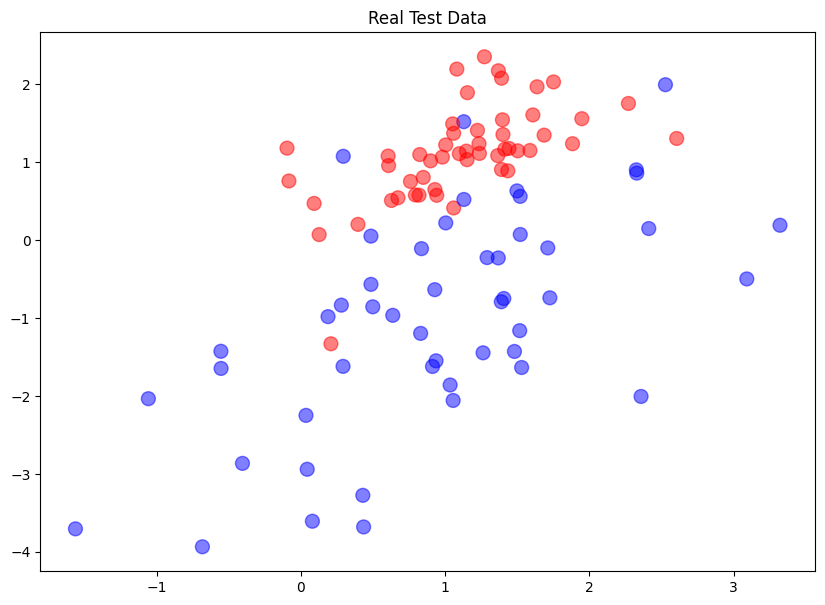

In [50]:
colors = ['r' if i else 'b' for i in Y_test]

fig = plt.figure(figsize=(10,7))
plt.title('Real Test Data')
plt.scatter(X_test[:, 0], X_test[:, 1], marker='o', c=colors, s=100, alpha = 0.5)
plt.show()

#### Алгоритм оптимизации SGD

In [51]:
model = NeuralFramework()
model.add_layers(layers = [Linear(2, 5), ReLU(), Linear(5, 3), Tanh(), Linear(3, 2), Sigmoid()],
                 loss_function = BinaryCrossEntropy())
model.train(X_train, Y_train)
pred_vals, acc = model.predict(X_test, Y_test)

print(f'\nFor binary classification accuracy = {acc}')

Training model:
Epoch 0: acc = 0.5
Epoch 1: acc = 0.5
Epoch 2: acc = 0.5
Epoch 3: acc = 0.37
Epoch 4: acc = 0.5
Epoch 5: acc = 0.5
Epoch 6: acc = 0.5
Epoch 7: acc = 0.5
Epoch 8: acc = 0.5
Epoch 9: acc = 0.5
Epoch 10: acc = 0.5
Epoch 11: acc = 0.5
Epoch 12: acc = 0.5
Epoch 13: acc = 0.5
Epoch 14: acc = 0.5
Epoch 15: acc = 0.5
Epoch 16: acc = 0.5
Epoch 17: acc = 0.5
Epoch 18: acc = 0.65
Epoch 19: acc = 0.5

For binary classification accuracy = 0.51


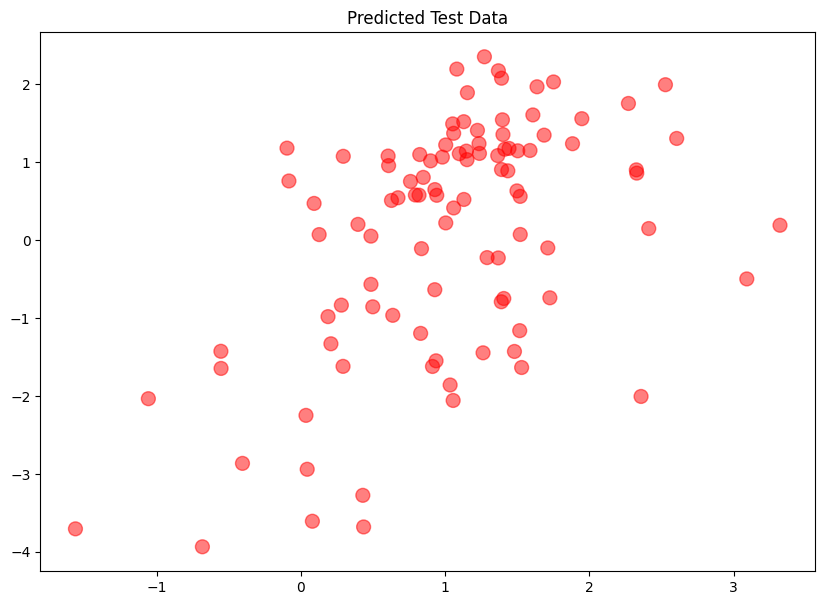

In [52]:
colors = ['r' if i else 'b' for i in pred_vals]

fig = plt.figure(figsize=(10,7))
plt.title('Predicted Test Data')
plt.scatter(X_test[:, 0], X_test[:, 1], marker='o', c=colors, s=100, alpha = 0.5)
plt.show()

#### Алгоритм оптимизации Momentum SGD

In [53]:
model = NeuralFramework()
model.add_layers(layers = [Linear(2, 5), ReLU(), Linear(5, 3), Tanh(), Linear(3, 2), Sigmoid()],
                 loss_function = BinaryCrossEntropy(), optimizer = MomentumSGD())
model.train(X_train, Y_train)
pred_vals, acc = model.predict(X_test, Y_test)

print(f'\nFor binary classification accuracy = {acc}')

Training model:
Epoch 0: acc = 0.5
Epoch 1: acc = 0.5
Epoch 2: acc = 0.5
Epoch 3: acc = 0.5
Epoch 4: acc = 0.5
Epoch 5: acc = 0.495
Epoch 6: acc = 0.495
Epoch 7: acc = 0.495
Epoch 8: acc = 0.495
Epoch 9: acc = 0.495
Epoch 10: acc = 0.495
Epoch 11: acc = 0.495
Epoch 12: acc = 0.505
Epoch 13: acc = 0.51
Epoch 14: acc = 0.5
Epoch 15: acc = 0.51
Epoch 16: acc = 0.535
Epoch 17: acc = 0.54
Epoch 18: acc = 0.55
Epoch 19: acc = 0.55

For binary classification accuracy = 0.55


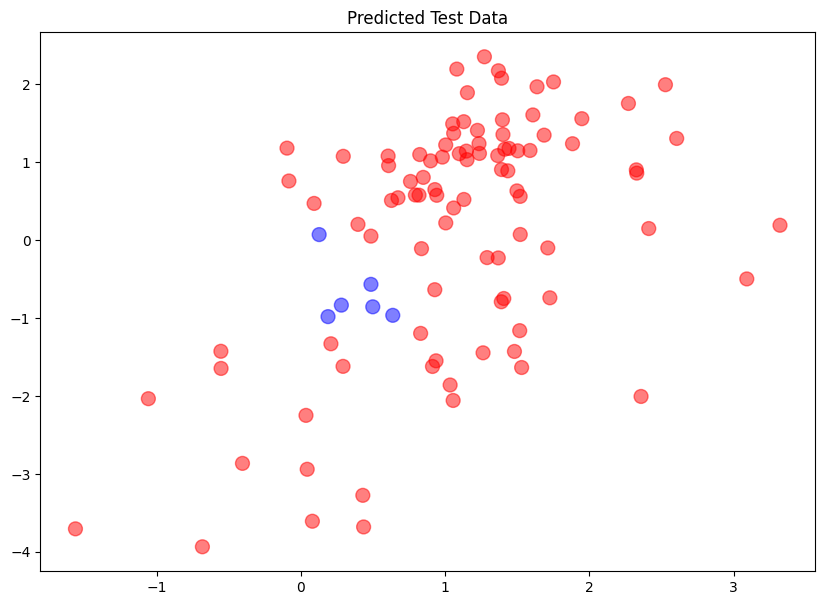

In [54]:
colors = ['r' if i else 'b' for i in pred_vals]

fig = plt.figure(figsize=(10,7))
plt.title('Predicted Test Data')
plt.scatter(X_test[:, 0], X_test[:, 1], marker='o', c=colors, s=100, alpha = 0.5)
plt.show()

#### Алгоритм оптимизации GradientClipping


In [48]:
model = NeuralFramework()
model.add_layers(layers = [Linear(2, 5), ReLU(), Linear(5, 3), Tanh(), Linear(3, 2), Sigmoid()],
                 loss_function = BinaryCrossEntropy(), optimizer = GradientClipping(7))
model.train(X_train, Y_train)
pred_vals, acc = model.predict(X_test, Y_test)

print(f'\nFor binary classification accuracy = {acc}')

Training model:
Epoch 0: acc = 0.5
Epoch 1: acc = 0.5
Epoch 2: acc = 0.5
Epoch 3: acc = 0.5
Epoch 4: acc = 0.5
Epoch 5: acc = 0.5
Epoch 6: acc = 0.5
Epoch 7: acc = 0.5
Epoch 8: acc = 0.69
Epoch 9: acc = 0.9
Epoch 10: acc = 0.89
Epoch 11: acc = 0.865
Epoch 12: acc = 0.915
Epoch 13: acc = 0.9
Epoch 14: acc = 0.905
Epoch 15: acc = 0.9
Epoch 16: acc = 0.885
Epoch 17: acc = 0.825
Epoch 18: acc = 0.9
Epoch 19: acc = 0.875

For binary classification accuracy = 0.87


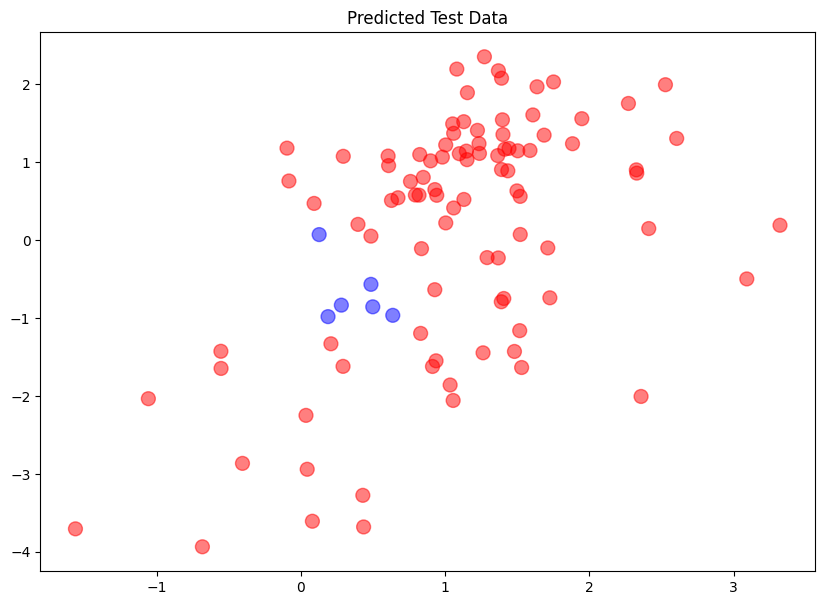

In [55]:
colors = ['r' if i else 'b' for i in pred_vals]

fig = plt.figure(figsize=(10,7))
plt.title('Predicted Test Data')
plt.scatter(X_test[:, 0], X_test[:, 1], marker='o', c=colors, s=100, alpha = 0.5)
plt.show()

### Регрессия

#### Алгоритм оптимизации GradienClipping

In [101]:
X, Y = make_regression(n_samples=samples_count, n_features=1, 
                       n_informative=1, noise = 10, random_state=0)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, 
                                                    test_size=test_count, 
                                                    random_state=42)

model = NeuralFramework()
model.add_layers(layers = [Linear(1, 1)],
                 loss_function = MeanSquaredError(), 
                 optimizer = GradientClipping(40), regression = True)   
model.train(X_train, Y_train)
pred_vals, loss = model.predict(X_test, Y_test)

print(f'\nFor regression loss = {loss}')

Training model:
Epoch 0: loss = 1350.4424146284766
Epoch 1: loss = 671.6403990637016
Epoch 2: loss = 1545.9509302972847
Epoch 3: loss = 1607.4420870726722
Epoch 4: loss = 1824.622647581319
Epoch 5: loss = 2051.1455087495624
Epoch 6: loss = 2052.074607335718
Epoch 7: loss = 1992.0770892301775
Epoch 8: loss = 1578.1888790214177
Epoch 9: loss = 2140.8454955920224
Epoch 10: loss = 2375.449525298533
Epoch 11: loss = 2334.086116441412
Epoch 12: loss = 1542.31956622723
Epoch 13: loss = 1252.9416557187637
Epoch 14: loss = 2597.909440859434
Epoch 15: loss = 2557.2503914848357
Epoch 16: loss = 2800.65443154961
Epoch 17: loss = 2834.414492839465
Epoch 18: loss = 1796.5987040367204
Epoch 19: loss = 1175.554175580291

For regression loss = 1744.8845322215075


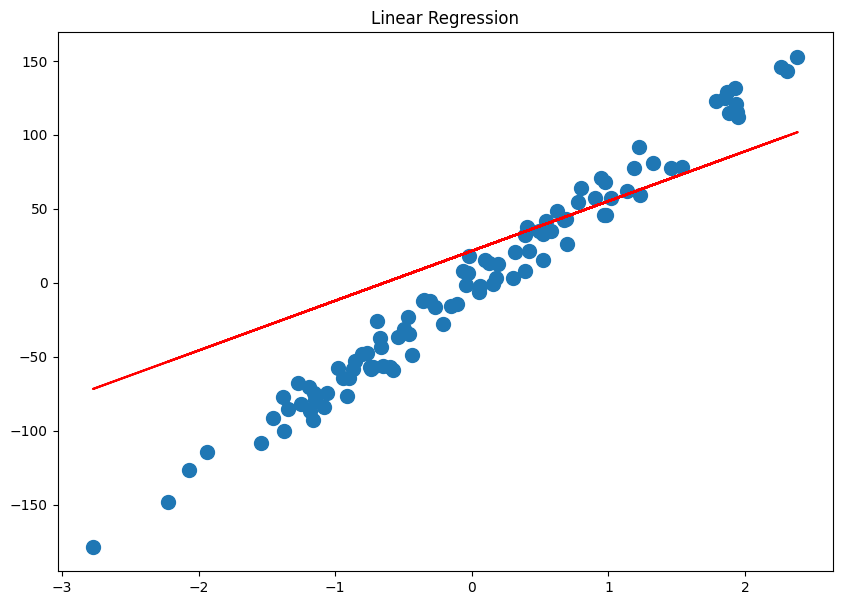

In [102]:
colors = ['r' if i else 'b' for i in pred_vals]

fig = plt.figure(figsize=(10,7))
plt.title('Linear Regression')
plt.scatter(X_test, Y_test, marker='o', s=100)
plt.plot(X_test, pred_vals, c='r')
plt.show()

#### Алгоритм оптимизации Momentum SGD

In [88]:
model = NeuralFramework()
model.add_layers(layers = [Linear(1, 1)],
                 loss_function = MeanSquaredError(), 
                 optimizer = MomentumSGD(), regression = True)   
model.train(X_train, Y_train)
pred_vals, loss = model.predict(X_test, Y_test)

print(f'\nFor regression loss = {loss}')

Training model:
Epoch 0: loss = 187.46100370245875
Epoch 1: loss = 86.69668379603213
Epoch 2: loss = 96.07970591222256
Epoch 3: loss = 80.94048209149892
Epoch 4: loss = 100.10524881843679
Epoch 5: loss = 117.70993968994821
Epoch 6: loss = 91.96264748988256
Epoch 7: loss = 111.65765415868006
Epoch 8: loss = 77.08775692147857
Epoch 9: loss = 78.40017821832036
Epoch 10: loss = 91.75058880493503
Epoch 11: loss = 165.452550522518
Epoch 12: loss = 63.260363115479436
Epoch 13: loss = 82.72603844956109
Epoch 14: loss = 99.00186328314005
Epoch 15: loss = 82.20992748316249
Epoch 16: loss = 168.76398595055468
Epoch 17: loss = 128.3330246193712
Epoch 18: loss = 58.446884120506276
Epoch 19: loss = 90.50018302345165

For regression loss = 114.7107394651809


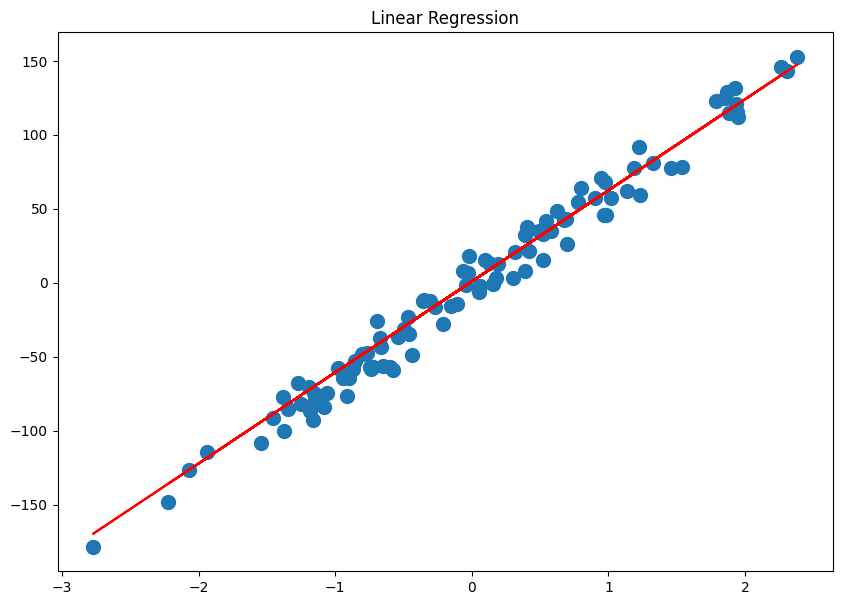

In [89]:
colors = ['r' if i else 'b' for i in pred_vals]

fig = plt.figure(figsize=(10,7))
plt.title('Linear Regression')
plt.scatter(X_test, Y_test, marker='o', s=100)
plt.plot(X_test, pred_vals, c='r')
plt.show()

#### Алгоритм оптимизации SGD

In [ ]:
model = NeuralFramework()
model.add_layers(layers = [Linear(1, 1)],
                 loss_function = MeanSquaredError(), regression = True)   
model.train(X_train, Y_train)
pred_vals, loss = model.predict(X_test, Y_test)

print(f'\nFor regression loss = {loss}')

Training model:
Epoch 0: loss = 53.464765370608596
Epoch 1: loss = 111.97611804025568
Epoch 2: loss = 105.66369059607992
Epoch 3: loss = 169.0986335394718
Epoch 4: loss = 96.29895283456665
Epoch 5: loss = 67.63255201249615
Epoch 6: loss = 86.83985801073091
Epoch 7: loss = 137.92773463300222
Epoch 8: loss = 117.53942849825947
Epoch 9: loss = 113.29866268575331
Epoch 10: loss = 78.94307757967319
Epoch 11: loss = 90.13608104245316
Epoch 12: loss = 130.3884951057467
Epoch 13: loss = 143.2052956392436
Epoch 14: loss = 138.03261222959665
Epoch 15: loss = 150.65957399156872
Epoch 16: loss = 82.17389500223024
Epoch 17: loss = 155.3025082388342
Epoch 18: loss = 107.7707349943197
Epoch 19: loss = 95.34727445899361

For regression loss = 109.61832882788873


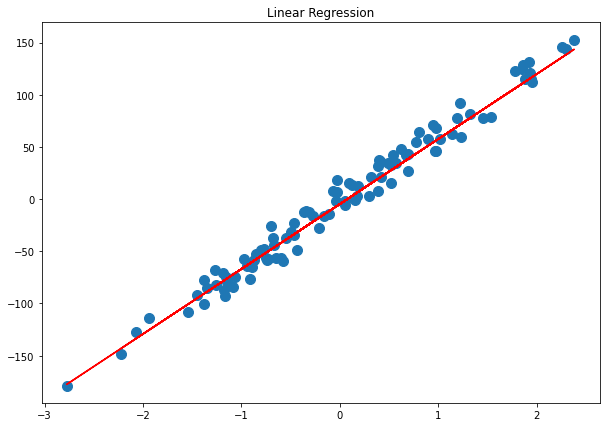

In [ ]:
colors = ['r' if i else 'b' for i in pred_vals]

fig = plt.figure(figsize=(10,7))
plt.title('Linear Regression')
plt.scatter(X_test, Y_test, marker='o', s=100)
plt.plot(X_test, pred_vals, c='r')
plt.show()

### MNIST

In [ ]:
(X_train, Y_train), (X_test, Y_test) = tf.keras.datasets.mnist.load_data()

X_train = X_train[0:1000]
Y_train = Y_train[0:1000]

X_test = X_test[0:200]
Y_test = Y_test[0:200]

X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)

# Scale images to the [0, 1] range
X_train = X_train.astype("float32") / 255
X_test = X_test.astype("float32") / 255

mnist_model = NeuralFramework()
mnist_model.add_layers(layers = [Linear(784, 1960), ReLU(), Linear(1960, 1176), Tanh(), Linear(1176, 10), Softmax()],
                 loss_function = CrossEntropyLoss())
mnist_model.train(X_train, Y_train)
pred_vals, acc = mnist_model.predict(X_test, Y_test)

print(f'For MNIST classification accuracy = {acc}')

Training model:
Epoch 0: acc = 0.575
Epoch 1: acc = 0.754
Epoch 2: acc = 0.787
Epoch 3: acc = 0.804
Epoch 4: acc = 0.824
Epoch 5: acc = 0.83
Epoch 6: acc = 0.849
Epoch 7: acc = 0.854
Epoch 8: acc = 0.86
Epoch 9: acc = 0.859
Epoch 10: acc = 0.872
Epoch 11: acc = 0.877
Epoch 12: acc = 0.879
Epoch 13: acc = 0.887
Epoch 14: acc = 0.889
Epoch 15: acc = 0.891
Epoch 16: acc = 0.893
Epoch 17: acc = 0.897
Epoch 18: acc = 0.903
Epoch 19: acc = 0.903
For MNIST classification accuracy = 0.86


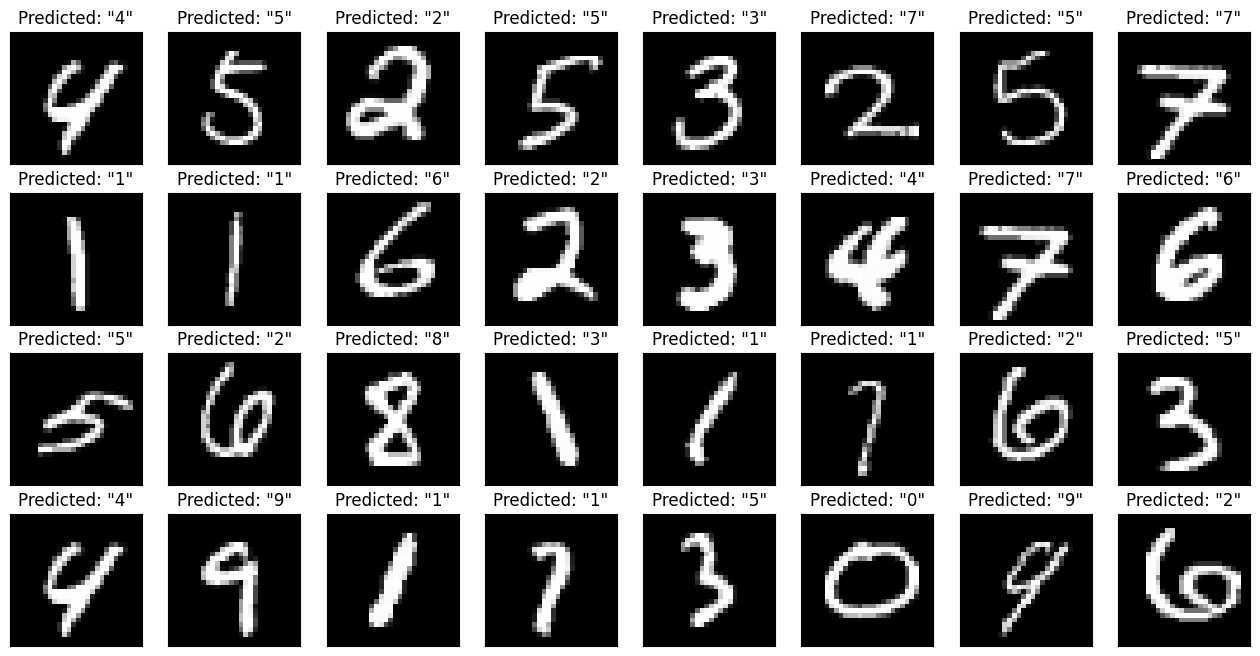

In [ ]:
n = X_test.shape[0]

nrows = 4
ncols = 8
_, ax = plt.subplots(nrows, ncols, figsize=(2*ncols, 2*nrows))
for k, nsample in enumerate(np.random.randint(low=0, high=n, size=nrows*ncols)):
    i = k // ncols
    j = k % ncols
    ax[i, j].imshow(X_test[nsample], cmap='gray')
    ax[i, j].set_title('Predicted: "{}"'.format(pred_vals[nsample]))
    ax[i, j].xaxis.set_visible(False)
    ax[i, j].yaxis.set_visible(False)

### Iris

In [144]:
iris = load_iris()
X, Y = iris.data[:, :3], iris.target
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, 
                                                    test_size=0.2, 
                                                    random_state=0)
iris_model = NeuralFramework()
iris_model.add_layers(layers = [Linear(3, 7), ReLU(), Linear(7, 5), Tanh(), Linear(5, 3), Softmax()],
                 loss_function = CrossEntropyLoss(), optimizer = MomentumSGD(), learning_rate = 0.0099)
iris_model.train(X_train, Y_train)
pred_vals, acc = iris_model.predict(X_test, Y_test)

print(f'For Iris classification accuracy = {acc}')

Training model:
Epoch 0: acc = 0.45
Epoch 1: acc = 0.55
Epoch 2: acc = 0.5666666666666667
Epoch 3: acc = 0.5333333333333333
Epoch 4: acc = 0.49166666666666664
Epoch 5: acc = 0.4583333333333333
Epoch 6: acc = 0.4666666666666667
Epoch 7: acc = 0.475
Epoch 8: acc = 0.5
Epoch 9: acc = 0.55
Epoch 10: acc = 0.5916666666666667
Epoch 11: acc = 0.6
Epoch 12: acc = 0.6083333333333333
Epoch 13: acc = 0.6083333333333333
Epoch 14: acc = 0.6166666666666667
Epoch 15: acc = 0.6333333333333333
Epoch 16: acc = 0.6333333333333333
Epoch 17: acc = 0.6333333333333333
Epoch 18: acc = 0.6333333333333333
Epoch 19: acc = 0.6333333333333333
For Iris classification accuracy = 0.8


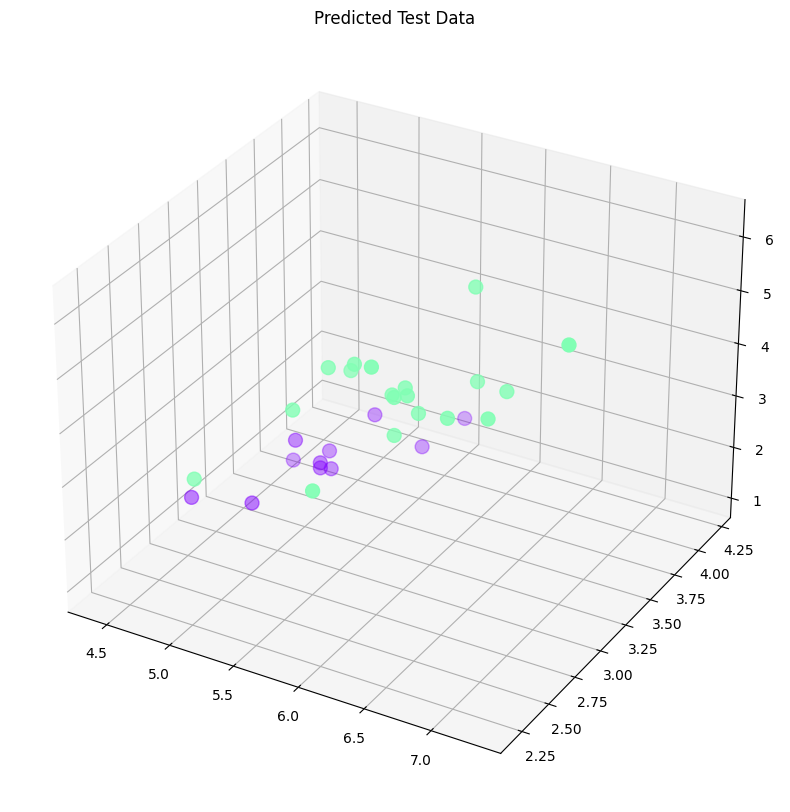

In [146]:
import matplotlib.cm as cm

fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')

colors = cm.rainbow(np.linspace(0, 1, len(X_test[0])))
plt.title('Predicted Test Data')
ax.scatter(X_test[:samples_count, 0], 
           X_test[:samples_count, 1], 
           X_test[:samples_count, 2], 
           s=100,
           c=[colors[i] for i in pred_vals[:samples_count]])

plt.show()